In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [2]:
# размеры шрифтов на графиках matplotlib

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
fracs_count = 4  # количество трещин
K_c = 1e6  # Па*м^(1/2) трещиностойкость породы

In [4]:
# параметры задачи в символьном виде

Q_0, p_0 = symbols('Q0 p0', real=True)  # суммарный расход на забое и забойное давление

Q = np.array(symbols(f'Q1:{fracs_count+1}', real=True))  # расходы на каждой из трещин
x_f = np.array(symbols(f'x_f1:{fracs_count+1}', real=True))  # полудлина каждой из трещин
E = np.array(symbols(f'E1:{fracs_count+1}', real=True))  # модуль плоской деформации породы вблизи каждой из трещин
h = np.array(symbols(f'h1:{fracs_count+1}', real=True))  # мощность продуктивной зоны для каждой из трещин
K, n, phi = symbols('K n phi', real=True)  # реологические параметры жидкости и геометрический параметр трещины
k_e = symbols('k_e', real=True)  # проницаемость пласта
p_e = symbols('p_e', real=True)  # пластовое давление
phi_e = symbols('phi_e', real=True)  # пористость пласта
c_t = symbols('c_t', real=True)  # общая сжимаемость
t = symbols('t', real=True)  # время
p_frac_net = np.array(symbols(f'p_frac_net1:{fracs_count+1}', real=True))  # чистые давления на каждой из трещин

n_p = np.array(symbols(f'n_p1:{fracs_count+1}', real=True))  # количество перфораций на каждой из трещин
d_p = np.array(symbols(f'd_p1:{fracs_count+1}', real=True))  # диаметр перфораций на каждой из трещин
C_d = np.array(symbols(f'C_d1:{fracs_count+1}', real=True))  # коэффициент эрозии на каждой из трещин
rho_s = symbols('rho_s', real=True)  # средняя плотность смеси

R = np.array(symbols(f'R1:{fracs_count+1}', real=True))  # радиус участков трубы к каждой из трещин
L = np.array(symbols(f'L1:{fracs_count+1}', real=True))  # длина участков трубы, ведущих к каждой из трещин

u_m = np.array(symbols(f'u_m1:{fracs_count+1}', real=True))  # средняя скорость на рассматриваемом участке к каждой из трещин
sigma_min = symbols(f'sigma_min1:{fracs_count+1}')  # давление закрытия для каждой из трещин

# для пошагового использования формулы Кёнинга
dQ = np.array(symbols(f'dQ1:{fracs_count+1}', real=True))  # изменения расходов на каждой из трещин
dp_f = np.array(symbols(f'dp_net1:{fracs_count+1}', real=True))  # изменения давлений на каждой из трещин
dt = symbols('dt', real=True)  # шаг по времени

In [5]:
# чистое давление в трещинах (без утечек)
def p_net_without_leak_off():
    V = h * (2 * x_f) * K_c * (S.Pi*h)**(1/2) / E
    a = (((n + 3) * (2 * n + 1)**n * K * E**(2*n+2)) / \
         (S.Pi * 2**(2 * n) * n**n * phi**n * \
          h**(3 * n + 3))) ** (1 / (2 * n + 3))
    p_net = a * Q**(n/(2*n+3)) * V**(1/(2*n+3))  # чистое давление на каждой из трещин
    return p_net

# чистое давление в трещинах (с утечками и доминированием трещиностойкости)
def p_net_with_leak_off():
    p_net = 2**(3/2) * K_c / (S.Pi * h)**(1/2)
    return p_net

# падение давления на перфорациях
def delta_p_perf():
    # падение давления на перфорациях на каждой из трещин
    delta_p_perf = 8 * rho_s / \
        (S.Pi**2 * C_d**2 * n_p**2 * d_p**4) * Q * abs(Q)
    return delta_p_perf

# падение давления на трение в трубе
def delta_p_fric():
    for i, _ in enumerate(u_m):
        u_m[i] = (Q_0 - sum([Q[j] for j in range(i)])) / (S.Pi * R[i]**2)
    delta_p_fric = 8 * (K / R) * (u_m / R) * L  # падение давления на трение в трубе для каждой из трещин
    return delta_p_fric

In [6]:
def kirchhoff_solver(parameter_values):
    all_eqns = np.array([])  # массив со всеми уравнениями законов Кирхгофа
    
    # добавляем левую часть уравнений второго закона Кирхгофа в массив all_eqns
    for i in range(fracs_count):
        all_eqns = np.append(all_eqns, p_0 - sigma_min[i] - \
                             p_net_with_leak_off()[i] - \
                            delta_p_perf()[i] - \
                            sum([delta_p_fric()[j] for j in range(i+1)]))

    # добавляем левую часть уравнения первого закона Кирхгофа в массив all_eqns
    all_eqns = np.append(all_eqns, Q_0 - sum(Q))
    
    # матрица Якоби
    J = np.zeros(shape=(fracs_count+1, fracs_count+1), dtype=object)
    for i, _ in enumerate(all_eqns):
        for j, _ in enumerate(Q):
            J[i, j] = diff(all_eqns[i], Q[j])
        J[i, -1] = diff(all_eqns[i], p_0)
    J_sym = Matrix(J)
    #display(J_sym)

    # начальные приближения числовых значений неизвестных параметров задачи
    solution_values = {}
    iterative_history = []
    for i in range(fracs_count):
        solution_values[Q[i]] = N(Q_0.subs(parameter_values)/fracs_count)  # расходы на каждой из трещин (начальное приближение)
    solution_values[p_0] = N(sigma_min[0].subs(parameter_values))  # забойное давление (начальное приближение)

    # вектор решения
    solution_vector = np.array(list(N(Matrix(Q).subs(solution_values))) + \
                               [N(p_0.subs(solution_values))],
                               dtype='float64').reshape(fracs_count+1,1)
    iterative_history.append(solution_vector.flatten())
    # предыдущий вектор решения
    last_solution_vector = solution_vector - 100

    dop_cond = 0

    # реализация метода Ньютона
    while np.linalg.norm(solution_vector - last_solution_vector) > 1e-4 or dop_cond < 10:
        # обновляем предыдущий вектор решения
        last_solution_vector = solution_vector.copy()
        # матрица Якоби
        #print(N(J_sym.subs({**parameter_values, **solution_values})))
        J = np.array(N(J_sym.subs({**parameter_values, **solution_values})),
                     dtype='float64')
        # вектор остатков
        residual_vector = np.array(
            N(Matrix(all_eqns).subs({**parameter_values, **solution_values})),
            dtype='float64'
        )
        # новый вектор решения
        solution_vector -= np.matmul(np.linalg.inv(J), residual_vector)
        iterative_history.append(solution_vector.flatten())
        for i, val in enumerate(solution_vector):
            if val < 0:
                solution_vector[i] = 1e-21
        # обновление значений текущего вектора решения в словаре solution_values
        for i in range(fracs_count):
            solution_values[Q[i]] = solution_vector.reshape(fracs_count+1,)[i]
        solution_values[p_0] = solution_vector.reshape(fracs_count+1,)[-1]
        dop_cond += 1
    return solution_values, iterative_history

In [7]:
# проверяю работу решателя Кирхгофа

parameter_values = {
    Q_0: 1000 / 86400,  # расход на забое, м^3/с
    K: 0.001,  # первый реологический параметр жидкости (вязкость воды), Па*с
    n: 1,  # второй реологический параметр жидкости (ньютоновская жидкость - вода)
#    phi: 0.3,  # безразмерный геометрический параметр трещины
    rho_s: 1000,  # плотность жидкости (воды), кг/м^3
    k_e: 1e-15,  # проницаемость, м^2
    phi_e: 0.2,  # пористость
    c_t: 2.2e-9,  # Па^(-1), общая сжимаемость
    p_e: 2.5e7  # Па, пластовое давление
}

for i in range(fracs_count):
    parameter_values[x_f[i]] = 1 # полудлина трещины, м
    parameter_values[E[i]] = 1e10  # модули плоской деформации породы, Па
    parameter_values[h[i]] = 15  # мощности продуктивной зоны, м
    parameter_values[n_p[i]] = 32  # количества перфораций
    parameter_values[d_p[i]] = 0.02  # диаметры перфораций, м
    parameter_values[C_d[i]] = 0.5  # безразмерные коэффициенты эррозии
    parameter_values[R[i]] = 0.08  # радиусы участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[L[i]] = 100  # длины участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[sigma_min[i]] = 4e7  # давления закрытия трещин, Па

#parameter_values[n_p[1]] = 16
#parameter_values[d_p[1]] = 0.005
#parameter_values[n_p[2]] = 1
#parameter_values[d_p[2]] = 0.01
#parameter_values[n_p[3]] = 4
#parameter_values[d_p[3]] = 0.001
#parameter_values[E[2]] = 2e10
#parameter_values[sigma_min[3]] = 4e7
#parameter_values[sigma_min[3]] = 1.02e7
solution_values, iterative_history = kirchhoff_solver(parameter_values)
display(solution_values)


{Q1: 0.0033802291521720144,
 Q2: 0.002975193576906111,
 Q3: 0.002685570544103208,
 Q4: 0.00253308080089274,
 p0: 40412323.8828565}

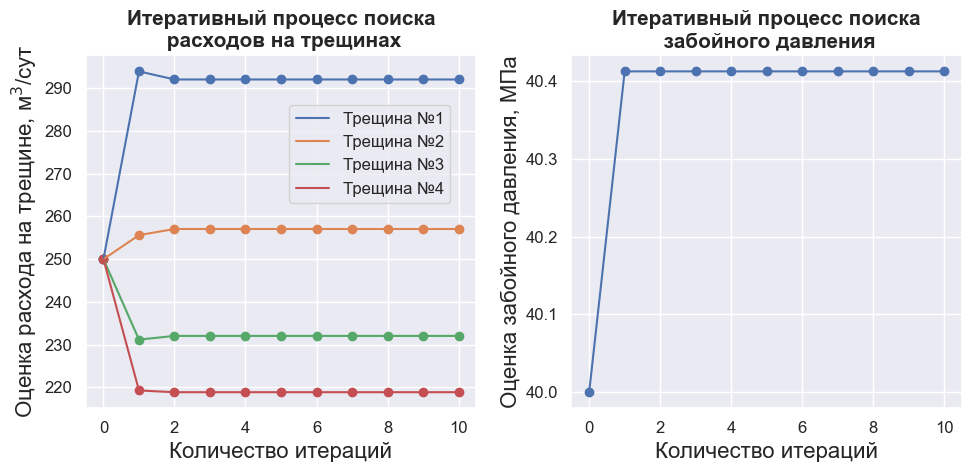

In [8]:
# построение графиков итерационного процесса решения

fig0, axs = plt.subplots(1, 2, figsize=(10,5))

for ii in range(fracs_count):
    axs[0].plot([i for i in range(len(iterative_history))],
                [item[ii]*86400 for item in iterative_history],
                label=f'Трещина №{ii+1}')
    axs[0].scatter([i for i in range(len(iterative_history))],
                   [item[ii]*86400 for item in iterative_history])
axs[0].set_title('Итеративный процесс поиска\n расходов на трещинах',
                 weight='bold',
                 size=15)
axs[0].set_xlabel('Количество итераций')
axs[0].set_ylabel('Оценка расхода на трещине, м$^3$/сут')
axs[0].legend(bbox_to_anchor=(0.5, 0.72), ncol=1)

axs[1].plot([i for i in range(len(iterative_history))],
            [item[fracs_count]/1e6 for item in iterative_history])
axs[1].scatter([i for i in range(len(iterative_history))],
               [item[fracs_count]/1e6 for item in iterative_history])
axs[1].set_title('Итеративный процесс поиска\n забойного давления',
                 weight='bold',
                 size=15)
axs[1].set_xlabel('Количество итераций')
axs[1].set_ylabel('Оценка забойного давления, МПа')

fig0.tight_layout()

fig0.savefig('myimage.jpg', dpi=300)

In [9]:
N(Q_0.subs(parameter_values))*86400

1000.00000000000

Text(0.5, 1.0, 'Давление вдоль скважины')

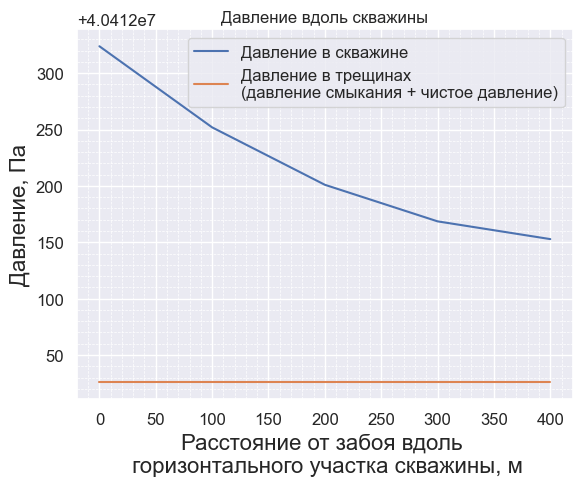

In [10]:
num_delta_p = [0]+[N(i.subs({**parameter_values, **solution_values})) for i in delta_p_fric()]
well_length_pressure = np.array([N(p_0.subs(solution_values))] * len(num_delta_p)) - np.cumsum(num_delta_p)
length = np.array([0, 100, 200, 300, 400])
fig = plt.figure()
plt.plot(length, well_length_pressure, label='Давление в скважине')
plt.plot(length, [N(p_net_with_leak_off()[1].subs(parameter_values))+sigma_min[1].subs(parameter_values)]*len(length),
         label='Давление в трещинах \n(давление смыкания + чистое давление)')
plt.legend()
plt.xlabel('Расстояние от забоя вдоль \n горизонтального участка скважины, м')
plt.ylabel('Давление, Па')
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.title('Давление вдоль скважины')

In [18]:
fig.savefig('pressure_distribution.jpg', dpi=300)

In [9]:
# формула Кёнинга
def koning_formula(leak_off_type='Carter'):
    if leak_off_type == 'Carter':
        kappa = k_e / (phi_e * K * c_t)
        x_frac = Q * K * ((S.Pi * kappa * t)**(1/2)) / \
            (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e))
    else:
        e_num = 2.718281828459045235
        kappa = k_e / (phi_e * K * c_t)
        under_exp = -2 * S.Pi * k_e * h * \
            (p_frac_net + sigma_min - p_e) / (Q * K)
        x_frac = 3 * (e_num)**(under_exp) * (kappa * t)**(1/2)
    return x_frac

# полная производная по времени формулы Кёнинга
def koning_formula_derivative(leak_off_type='Carter'):
    if leak_off_type == 'Carter':
        kappa = k_e / (phi_e * K * c_t)
        dx_frac = K * ((S.Pi * kappa * t)**(1/2)) * dQ / \
            (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e)) + \
            Q * K * ((S.Pi * kappa / t)**(1/2)) * dt / \
                (4 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e)) - \
            Q * K * ((S.Pi * kappa * t)**(1/2)) * dp_f / \
                (2 * S.Pi * k_e * h * (p_frac_net + sigma_min - p_e)**2)
    else:
        e_num = 2.718281828459045235
        under_exp = -2 * S.Pi * k_e * h * \
            (p_frac_net + sigma_min - p_e) / (Q * K)
        kappa = k_e / (phi_e * K * c_t)
        dx_frac = 6 * S.Pi * k_e * h * \
            (p_frac_net + sigma_min - p_e) * dQ / (Q**2 * K) * \
                (e_num)**(under_exp) * (kappa * t)**(1/2) + \
                    3/2 * (e_num)**(under_exp) * (kappa / t)**(1/2) * dt - \
                    6 * S.Pi * k_e * h / (Q * K) * (e_num)**(under_exp) * (kappa * t)**(1/2) * dp_f
    return dx_frac


Text(0.5, 1.0, 'Количество шагов по времени: 801')

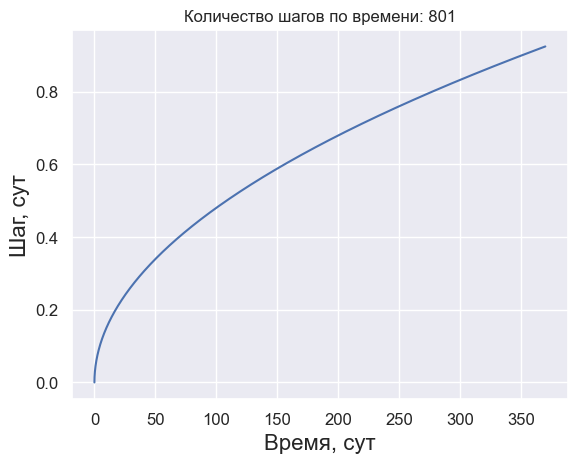

In [10]:
time_mesh = np.concatenate([np.array([0.1]), np.arange(1, 80000, 100)])
#time_mesh = np.concatenate([np.array([0.1]), np.arange(1, 670000, 7000)])
for i, val in enumerate(time_mesh[1:]):
    time_mesh[i+1] += time_mesh[i]
#time_mesh = time_mesh[:30]
#time_mesh = np.arange(0.1,10.5,0.1)
plt.plot(time_mesh[1:] / 86400, (time_mesh[1:]-time_mesh[:-1]) / 86400)
plt.xlabel('Время, сут')
plt.ylabel('Шаг, сут')
plt.title(f'Количество шагов по времени: {len(time_mesh)}')
#time_mesh

In [11]:
#leak_off_regime = '2D'
leak_off_regime = 'Carter'

#flow_start = 1700 / 86400
#flow_end = 1000 / 86400

diam_start = 0.02
#diam_end = 0.005
diam_end_2 = 0.01
#diam_end_3 = 0.015

#sigma_start = 4e7
#sigma_end = 3.8e7

display_output = False

for_koning_values = {}

for_koning_values[t] = time_mesh[0]
for_koning_values[dt] = time_mesh[1] - time_mesh[0]

# список забойных давлений
p_0_values = []
# список чистых давлений в трещинах
p_net_values = []
# список дебитов на трещинах
Q_values = []
# список полудлин трещин
x_frac_values = []  # через приращение
x_frac_values_via_formula = []  # просто по формуле
# список минимальных чистых давлений в трещине для её распространения
p_net_prop_values = []

for t_ind, t_value in enumerate(tqdm(time_mesh[:-1])):

    sigma_last = parameter_values[sigma_min[0]]

    #parameter_values[sigma_min[0]] = sigma_start + (sigma_end-sigma_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])
    #parameter_values[sigma_min[1]] = sigma_start + (sigma_end-sigma_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])
    #parameter_values[sigma_min[2]] = sigma_start + (sigma_end-sigma_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])
    #parameter_values[sigma_min[3]] = sigma_start + (sigma_end-sigma_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])

    #parameter_values[Q_0] = flow_start + (flow_end-flow_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0]) + 100/86400 * np.sin(t_value/(86400 * 15))
    #parameter_values[d_p[1]] = diam_start + (diam_end-diam_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])
    
    #print(parameter_values[Q_0])
    parameter_values[d_p[2]] = diam_start + (diam_end_2-diam_start) * \
        (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])
    
    #parameter_values[d_p[3]] = diam_start + (diam_end_3-diam_start) * \
    #    (t_value-time_mesh[0])/(time_mesh[-1]-time_mesh[0])

    #parameter_values[Q_0] = (1000 + 200 * np.sin(t_value/(86400 * 15)))/86400
    
    #if t_value >= 70 * 86400:
        #parameter_values[C_d[1]] = 0.6
        #parameter_values[d_p[1]] = 0.01
    
    #if t_value >= 140 * 86400:
        #parameter_values[C_d[2]] = 0.7
        #parameter_values[d_p[2]] = 0.01
    
    #if t_value >= 210 * 86400:
    #    parameter_values[C_d[3]] = 0.8

    if t_value > time_mesh[0]:
        solution_values_last = solution_values.copy()

    solution_values, _ = kirchhoff_solver(parameter_values)

    p_0_value = solution_values.get(p_0)
    p_0_values.append(p_0_value)

    Q_value = [solution_values[symbols('Q'+str(i), real=True)]
               for i in range(1, fracs_count+1)]
    Q_values.append(Q_value)

    p_net_value = [N(i.subs({**parameter_values, **solution_values}))
                   for i in p_net_with_leak_off()]
    p_net_values.append(p_net_value)

    for i in range(fracs_count):
        for_koning_values[p_frac_net[i]] = p_net_value[i]
    
    p_net_prop = K_c / (S.Pi * x_f)**(1/2)
    p_net_prop_value = [N(i.subs({**parameter_values}))
                        for i in p_net_prop]
    p_net_prop_values.append(p_net_prop_value)
    
    if t_value == time_mesh[0]:
        x_frac = [N(i.subs({**parameter_values, **solution_values,
                            **for_koning_values}))
                            for i in koning_formula(
                                leak_off_type=leak_off_regime)]
    else:
        for i in range(fracs_count):
            for_koning_values[dQ[i]] = Q_values[-1][i] - Q_values[-2][i]
            for_koning_values[dp_f[i]] = p_net_values[-1][i] - \
                p_net_values[-2][i] + parameter_values[sigma_min[i]] - sigma_last
        dx_frac = [N(i.subs({**parameter_values, **solution_values,
                             **for_koning_values}))
                             for i in koning_formula_derivative(
                                 leak_off_type=leak_off_regime)]
        #dx_frac = [el if el >= 0 else 0 for el in dx_frac]
        #for i in range(fracs_count):
        #    if for_koning_values[p_frac_net[i]] < p_net_prop_values[-1][i]:
        #        dx_frac[i] = 0
        x_frac = np.array(x_frac_values[-1]) + np.array(dx_frac)
    x_frac_values.append(x_frac)

    x_frac_values_via_formula.append(np.array(
        [N(i.subs({**parameter_values,
                   **solution_values,
                   **for_koning_values})
           ) for i in koning_formula(leak_off_type=leak_off_regime)]))

    #print(x_frac)

    for i in range(fracs_count):
        parameter_values[x_f[i]] = x_frac[i]
    
    #print(p_net_prop_value)
    #print(p_net_value)
    for_koning_values[t] = time_mesh[t_ind+1]
    for_koning_values[dt] = time_mesh[t_ind+1] - time_mesh[t_ind]
    

    #if for_koning_values[t] >= 100:
    #    parameter_values[d_p[1]] = 0.005

    if display_output:
        print(x_frac, 'метров')
        print(for_koning_values[t], ' сек')

100%|██████████| 800/800 [1:37:19<00:00,  7.30s/it]


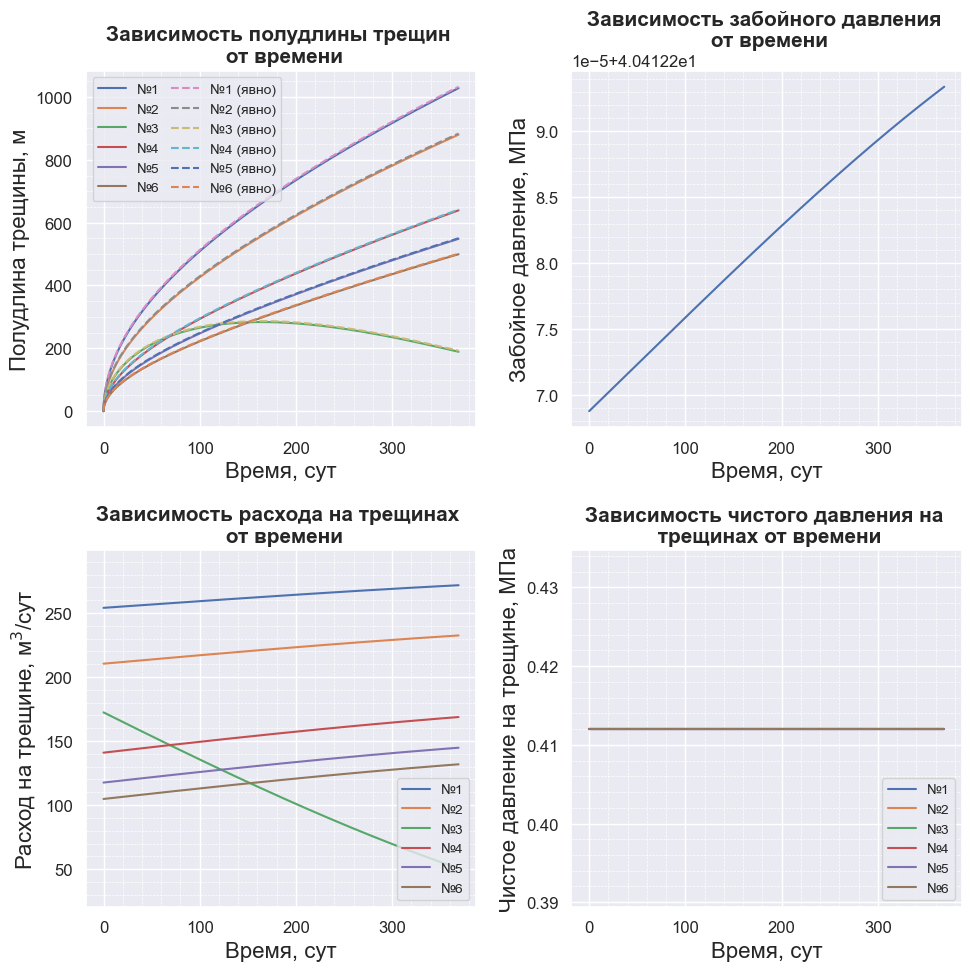

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

plt.rc('legend', fontsize=10)

axs[0,0].plot(time_mesh[:-1] / 86400, x_frac_values,
              label=[f'№{i+1}' for i in range(fracs_count)])
axs[0,0].plot(time_mesh[:-1] / 86400, x_frac_values_via_formula,
              linestyle='--', label=[f'№{i+1} (явно)'
                                     for i in range(fracs_count)])
axs[0,0].set_xlabel('Время, сут')
axs[0,0].set_ylabel('Полудлина трещины, м')
axs[0,0].set_title('Зависимость полудлины трещин \n от времени',
                   weight='bold',size=15)
axs[0,0].legend(ncol=2, columnspacing=0.8)
axs[0,0].minorticks_on()
axs[0,0].grid(which='minor', linestyle='--', linewidth=0.5)

axs[0,1].plot(time_mesh[:-1]/86400, np.array(p_0_values)/1e6)
axs[0,1].set_xlabel('Время, сут')
axs[0,1].set_ylabel('Забойное давление, МПа')
axs[0,1].set_title('Зависимость забойного давления \n от времени',
                   weight='bold',size=15)
axs[0,1].minorticks_on()
axs[0,1].grid(which='minor', linestyle='--', linewidth=0.5)

axs[1,0].plot(time_mesh[:-1]/86400, np.array(Q_values)*86400,
              label=[f'№{i+1}' for i in range(fracs_count)])
axs[1,0].set_ylim([0.4*min(np.array(Q_values).flatten())*86400,
                   1.1*max(np.array(Q_values).flatten())*86400])
axs[1,0].set_xlabel('Время, сут')
axs[1,0].set_ylabel('Расход на трещине, м$^3$/сут')
axs[1,0].set_title('Зависимость расхода на трещинах \n от времени',
                   weight='bold',size=15)
axs[1,0].legend()
axs[1,0].minorticks_on()
axs[1,0].grid(which='minor', linestyle='--', linewidth=0.5)



axs[1,1].plot(time_mesh[:-1]/86400, np.array(p_net_values)/1e6,
              label=[f'№{i+1}' for i in range(fracs_count)])
#axs[1,1].plot(time_mesh[:-1]/86400, np.array(p_net_prop_values)/1e6,
#              linestyle='--',
#              label=[f'Усл. распр. на трещине №{i+1}'
#                     for i in range(fracs_count)])
axs[1,1].set_xlabel('Время, сут')
axs[1,1].set_ylabel('Чистое давление на трещине, МПа')
axs[1,1].set_title('Зависимость чистого давления на \n трещинах от времени',
                   weight='bold',size=15)
axs[1,1].legend(loc="lower right")
axs[1,1].minorticks_on()
axs[1,1].grid(which='minor', linestyle='--', linewidth=0.5)

fig.tight_layout()

In [13]:
fig.savefig('myimage13.jpg', dpi=300)

In [14]:
x_frac = [N(i.subs({**parameter_values, **solution_values, **for_koning_values})) for i in koning_formula()]
x_frac

[1033.96716507938,
 884.673408596615,
 192.598489102508,
 642.237803466833,
 551.076059646421,
 501.833025694447]